In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout


In [4]:
#path to dataframe containing genes in every gene set
DATA_DIR =  #path to directory containing .csv files for knowledge base
gene_sets_path = DATA_DIR + '/Cytopus_1.31nc_gene-sets_x_genes.csv'
#path to dataframe containing metadata about the gene sets
metadata_path = DATA_DIR + '/Cytopus_1.31nc_versions_metadata.csv'
#path tto dataframe containing the cell type hierarchy
cellular_hierarchies_path = DATA_DIR + '/Cytopus_1.31nc_hierarchies.csv'

In [ ]:
%pip install cytopus

# prepare data

## construct cell type hierarchy

We first construct the hierarchy of cell types to which we will then attach the genes sets. For this we need a list of cell types and a list of tuples indicating the all edges between cell types in the format:

celltype_edges = [('celltype_child_1','celltype_parent_1'),('celltype_child_2','celltype_parent_2'),...]

In [5]:
#here we import this information from a dataframe storing the child nodes in column index 0 and parent nodes in column index 1.
cellular_hierarchies= pd.read_csv(cellular_hierarchies_path)
cellular_hierarchies.head()

,parent,child
0,all-cells,leukocyte
1,leukocyte,M
2,leukocyte,TNK
3,TNK,ILC
4,leukocyte,B


In [6]:
 #transform information in dataframe to list of tuples
 celltype_edges = list(zip(list(cellular_hierarchies['child']),list(cellular_hierarchies['parent'])))
 celltype_edges[:10]

[('leukocyte', 'all-cells'),
 ('M', 'leukocyte'),
 ('TNK', 'leukocyte'),
 ('ILC', 'TNK'),
 ('B', 'leukocyte'),
 ('B-naive', 'B'),
 ('epi', 'all-cells'),
 ('carcinoma-cell', 'epi'),
 ('NSCLC-carcinoma-cell', 'carcinoma-cell'),
 ('lung-epi', 'epi')]

## get gene sets and metadata

We first connect genes with their respective gene sets by edges. For this we format the data as it follows:

geneset_gene_edges = [('gene_set_1','gene_1'),('gene_set_2','gene_2'),..]

In [7]:
#here we load the genes belong to each gene set
gene_sets = pd.read_csv(gene_sets_path)
gene_sets.head()


,gene_set_name,gene_name
0,leuko_transendothelial-migration,ESAM
1,leuko_transendothelial-migration,MYLPF
2,leuko_transendothelial-migration,CTNNA2
3,leuko_transendothelial-migration,MYL12A
4,leuko_transendothelial-migration,TXK


In [8]:
#geneset gene edges
geneset_gene_edges = list(zip(list(gene_sets['gene_set_name']),list(gene_sets['gene_name'])))
geneset_gene_edges[:10]

[('leuko_transendothelial-migration', 'ESAM'),
 ('leuko_transendothelial-migration', 'MYLPF'),
 ('leuko_transendothelial-migration', 'CTNNA2'),
 ('leuko_transendothelial-migration', 'MYL12A'),
 ('leuko_transendothelial-migration', 'TXK'),
 ('leuko_transendothelial-migration', 'CLDN8'),
 ('leuko_transendothelial-migration', 'PTK2B'),
 ('leuko_transendothelial-migration', 'MMP9'),
 ('leuko_transendothelial-migration', 'PTPN11'),
 ('leuko_transendothelial-migration', 'CLDN9')]

In [9]:
#here we load the metadata from a data frame, this contains the gene set name, version, cell type, author and information about licensing
metadata = pd.read_csv(metadata_path,index_col='gene_set_name')
metadata.head()

,version_id,cell_type_name,annotation_name,author,license,license_link,license_type,gene_set_type,gene_set_topic,Column1,Column2
gene_set_name,,,,,,,,,,,
leuko_transendothelial-migration,v_hs217,leukocyte,cellular_process,GO Term 2019-01-01: 10.5281/zenodo.2529950_210...,Creative Commons Attribution 4.0 Unported Lic...,http://geneontology.org/docs/go-citation-policy/,c,manual_external,immune_function,NaN,NaN
CD4-T_TH22_UP,v_hs65b,CD4-T,cellular_process,wallet,MIT,https://github.com/wallet-maker/cytopus/blob/m...,c,manual_internal,immune_function,NaN,NaN
all_autophagic-cell-death,v_hs220,all-cells,cellular_process,GO Term 2019-01-01: 10.5281/zenodo.2529950_210...,Creative Commons Attribution 4.0 Unported Lic...,http://geneontology.org/docs/go-citation-policy/,c,manual_external,cell_death_autophagy,NaN,NaN
all_n-glycan_degradation,v_hs160,all-cells,cellular_process,10.1038/ncomms13041,NaN,NaN,c,manual_external,metabolism,NaN,NaN
T_central-memory_UP,v_hs78b,TCM,cellular_identity,wallet,MIT,https://github.com/wallet-maker/cytopus/blob/m...,c,manual_internal,immune_identity,NaN,NaN


In [10]:
#we format the data identically for the geneset celltype edges
geneset_celltype_edges = list(zip(list(metadata.index),list(metadata['cell_type_name'])))
geneset_celltype_edges[:10]

[('leuko_transendothelial-migration', 'leukocyte'),
 ('CD4-T_TH22_UP', 'CD4-T'),
 ('all_autophagic-cell-death', 'all-cells'),
 ('all_n-glycan_degradation', 'all-cells'),
 ('T_central-memory_UP', 'TCM'),
 ('all_actin-cytoskeleton_regulation', 'all-cells'),
 ('lung-epi_IL13_response', 'lung-epi'),
 ('all_mitophagy', 'all-cells'),
 ('T_CD4-T_UP', 'CD4-T'),
 ('all_steroid_metabolism', 'all-cells')]

We also need to classify our gene sets into cellular processes (gene programs) or identities (cell type markers)

In [11]:
#provide a dictionary indicating the gene set annotation names
annotation_dict = metadata['annotation_name'].to_dict()
annotation_dict

{'leuko_transendothelial-migration': 'cellular_process',
 'CD4-T_TH22_UP': 'cellular_process',
 'all_autophagic-cell-death': 'cellular_process',
 'all_n-glycan_degradation': 'cellular_process',
 'T_central-memory_UP': 'cellular_identity',
 'all_actin-cytoskeleton_regulation': 'cellular_process',
 'lung-epi_IL13_response': 'cellular_process',
 'all_mitophagy': 'cellular_process',
 'T_CD4-T_UP': 'cellular_identity',
 'all_steroid_metabolism': 'cellular_process',
 'all_MHC-I-presentation': 'cellular_process',
 'all_DNA_synthesis': 'cellular_process',
 'M_cDC2_UP': 'cellular_identity',
 'all_ketone-body_metabolism': 'cellular_process',
 'all_fatty-acid-beta-oxidation-peroxisomal': 'cellular_process',
 'all_MHC-II-presentation': 'cellular_process',
 'all_riboflavin_metabolism': 'cellular_process',
 'all_fatty-acid-metabolism': 'cellular_process',
 'B_memory-non-switched_UP': 'cellular_identity',
 'all_ubiquinone_synthesis': 'cellular_process',
 'all_galactose_metabolism': 'cellular_process'

You can add additional metadata to the gene sets (optional). Provide this data as a nested dictionary of the format:

{'gene_set_1':{'attribute_type_1':'attribute_a',
               'attribute_type_2':'attribute_b',....}...}

In [12]:
metadata_columns = ['version_id', 'author', 'license',
       'license_link', 'license_type', 'gene_set_type', 'gene_set_topic']
metadata_dict = metadata[metadata_columns].to_dict('index')

# construct the KnowledgeBase

In [15]:
#if you want to save the data set save to True and provide the saving location as save_path
import cytopus as cp
G = cp.create.construct_kb(celltype_edges, geneset_gene_edges,geneset_celltype_edges,annotation_dict,metadata_dict=metadata_dict,save=True, save_path=DATA_DIR+'Cytopus_1.31nc.txt'
)
G

all cell types in gene set are contained in the cell type hierarchy
Pickled and saved to: /home/wallet/Downloads/1.31nc/Cytopus_1.31nc.txt
KnowledgeBase object containing 92 cell types and 201 cellular processes



all celltypes in knowledge base: ['CD8-T_terminal-exhaustion', 'colon-epi', 'crc-carcinoma-cell', 'ILC1', 'CD8-T_KLRG1pos-effector', 'NK', 'endo-lymphatic', 'CD4-T', 'CD8-T', 'endo', 'CD56bright-NK', 'CD4-TCM', 'cDC3', 'endo-arterial', 'B-pb-t2', 'CD8-Teffector', 'Langerhans', 'iNKT', 'M', 'FDC', 'CD8-TSCM', 'T', 'cDC', 'CD8-TRM', 'TRM', 'NK-adaptive', 'TFH', 'MAIT', 'capillary', 'ILC2', 'T-naive', 'endo-aerocyte', 'mono', 'B', 'DC', 'baso', 'gdT', 'ILC', 'TSCM', 'B-pb-mature', 'CD4-TSCM', 'MDC', 'ILC3-NCRneg', 'lung-smooth-muscle', 'mo-DC', 'gran', 'CD4-Teffector', 'TEM', 'neutro', 'B-memory-IgM-MZ', 'Lti', 'p-DC', 'mast', 'all-cells', 'B-naive', 'cDC1', 'CD56dim-NK', 'epi', 'CD8-T-progenitor-exhausted', 'cDC2', 'B-pb-t1', 'carcinoma-cell', 'TCM', 'TNK', 'ILC3-NCRpos', 'nc-mono', 'plasma-blast', 'leukocyte', 'c-mono', 'Mac', 'smooth-muscle', 'CD4-TRM', 'CD8-TEM', 'GC-B', 'CD8-T_KLRG1neg-effector', 'ILC3', 'lung-endo-venous', 'B-memory', 'eosino', 'B-memory-non-switched', 'fibro', 'B-m

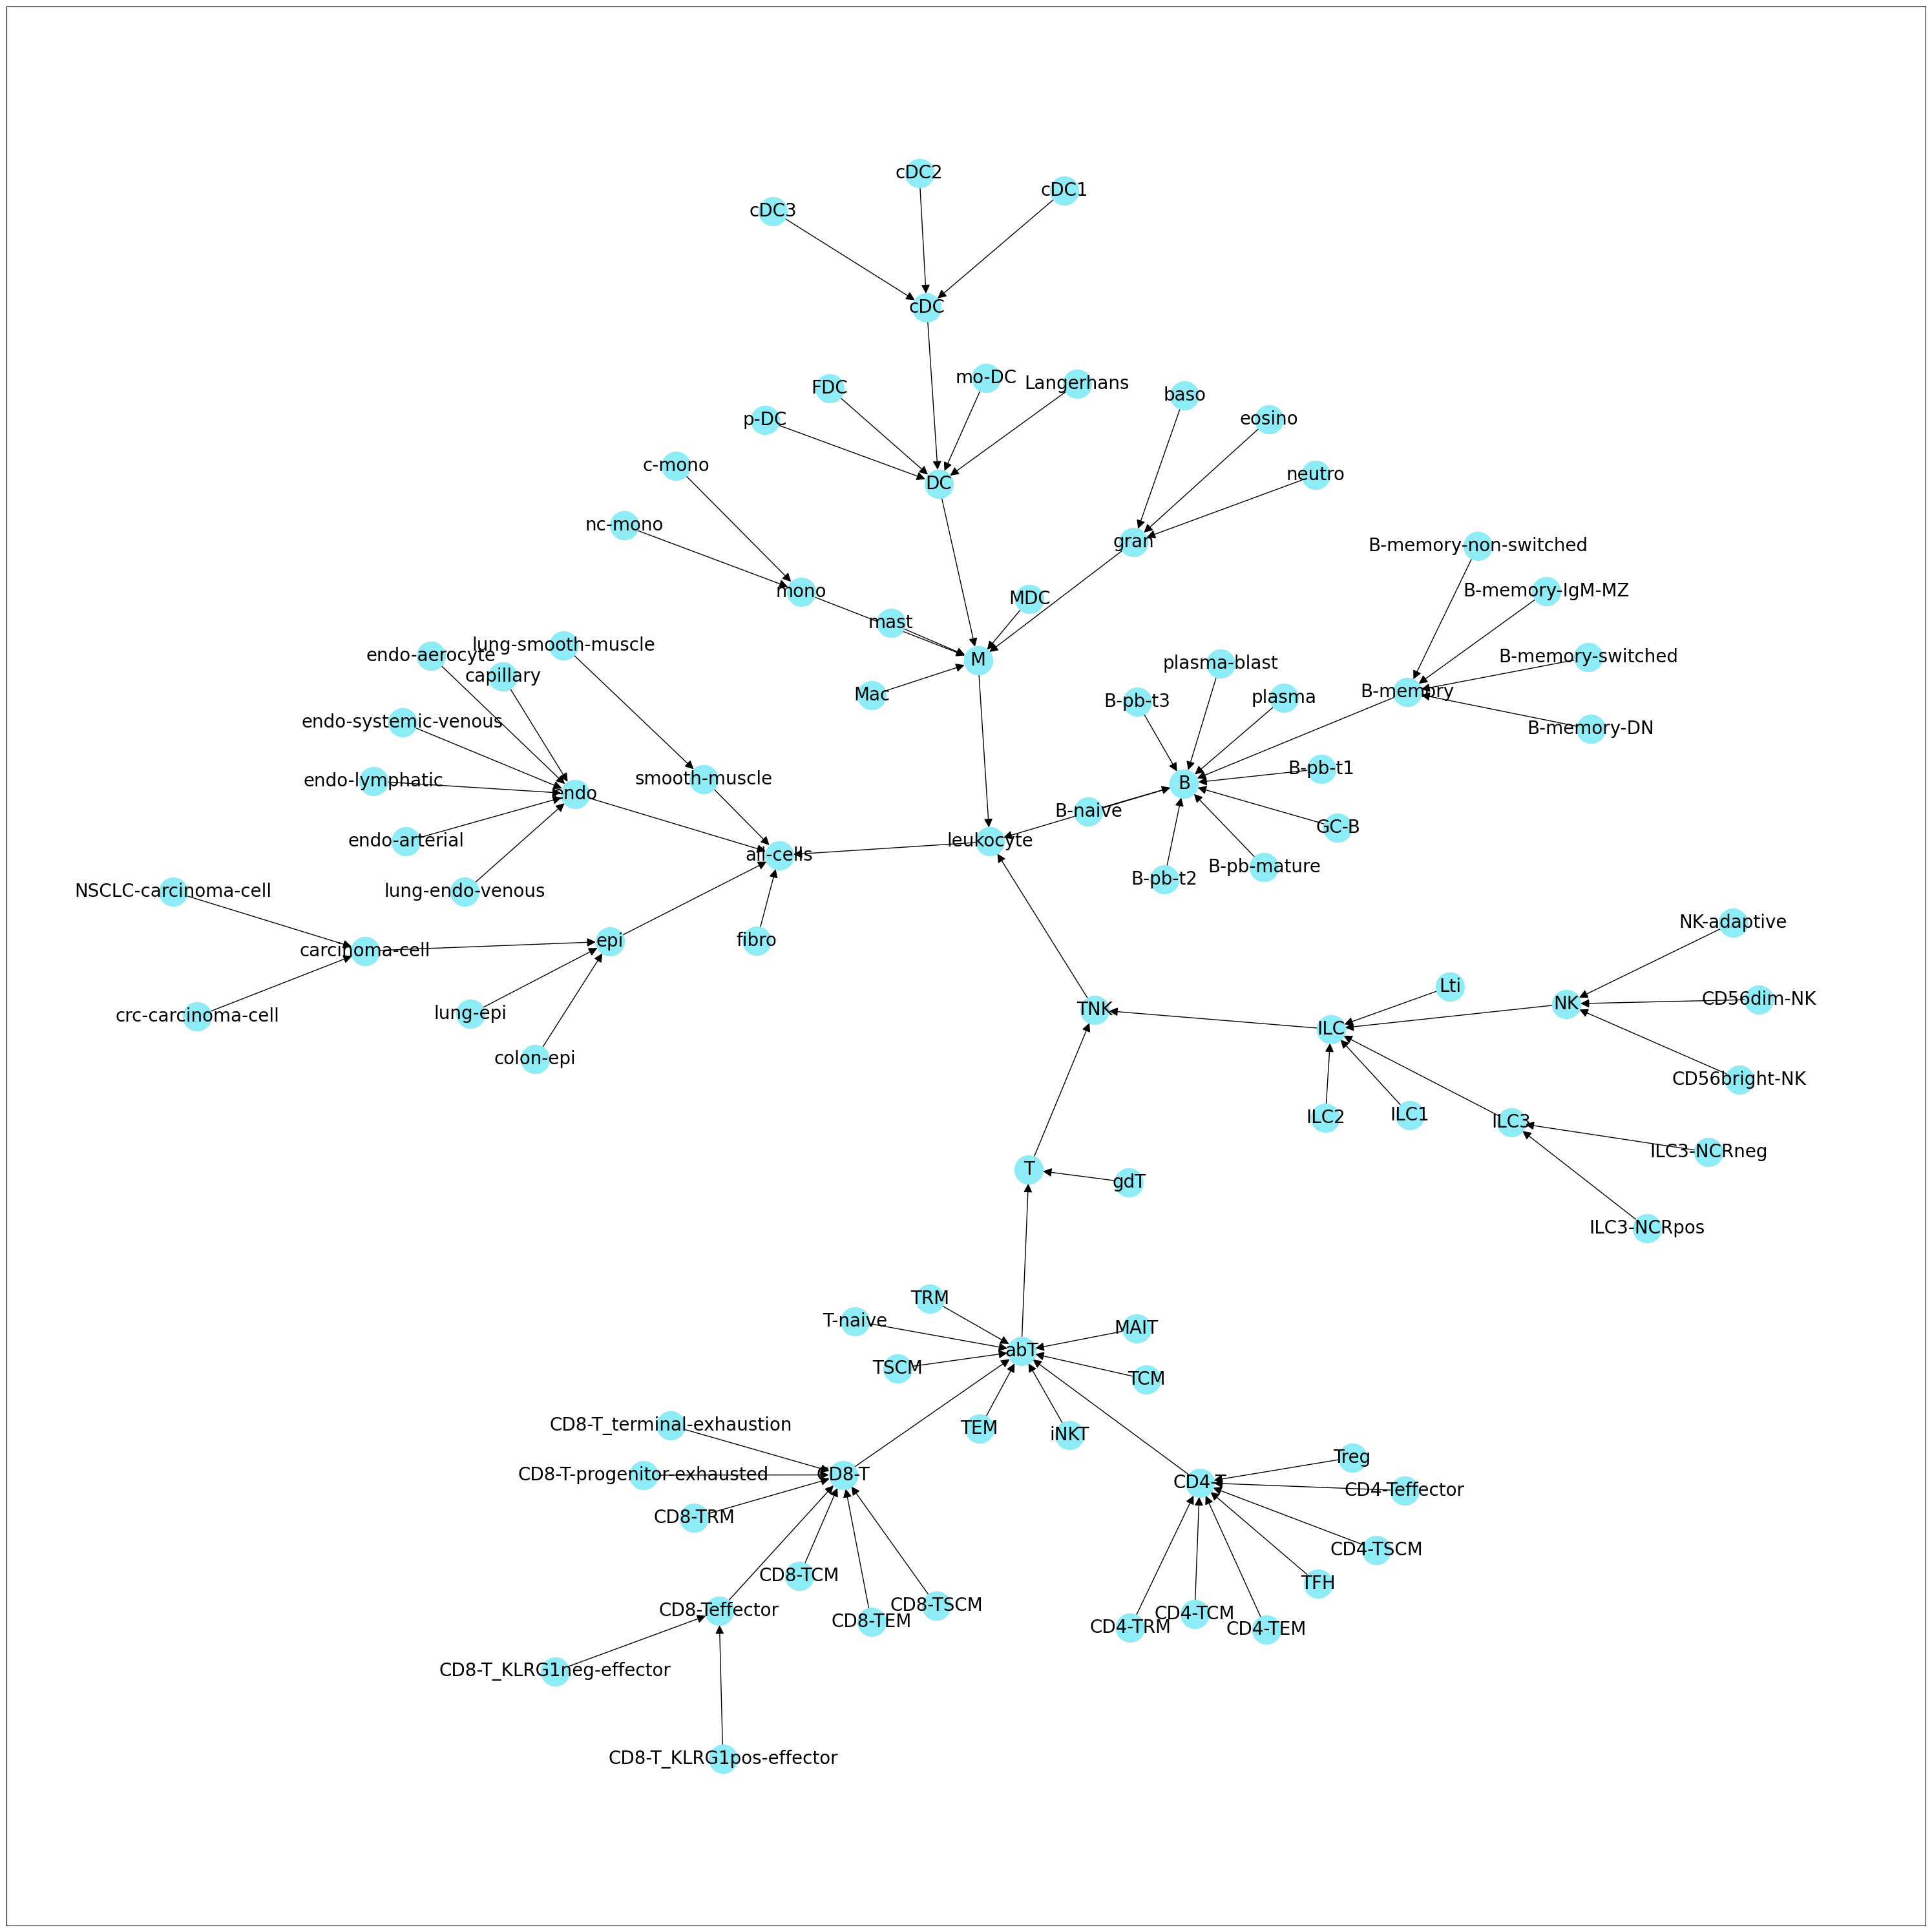

In [16]:
#plot the cell type hierarchy
G.plot_celltypes()